In [118]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))\

import numpy as np
import pandas as pd
import GPy
try:
    from google.colab import files
    uploaded = files.upload()
except ImportError:
    pass
    
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale, normalize
    
%matplotlib inline

In [133]:
df=pd.read_csv('bitcoin_start-240418.csv')

In [134]:
df=df[:-2]
df["Dataindex"] = df.index                        ## Keep index, could be usefull
df.index=df.Date    
df.index=df.index.to_datetime()
df=df.drop(columns=['Date'])

 /m/home/home2/27/holopaj7/unix/Envs/CS-Major/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning:to_datetime is deprecated. Use pd.to_datetime(...)


In [135]:
#take log scale
df['Close Price Log']=np.log(df['Close Price'])
#Normalize
submean = df['Close Price'] - np.mean(df['Close Price'])
normalized = submean / np.sqrt(np.var(df['Close Price']))
df['Close Price Normalized'] = normalized

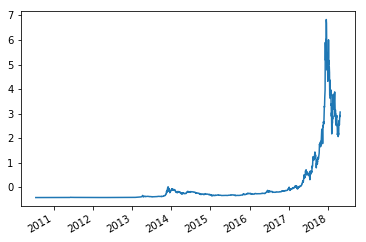

In [140]:
df['Close Price Normalized'].plot()

### Data of one year

In [141]:
## PREPROCESSING

df["Weekday"] = df.index.weekday                 ## 0 = Monday, 6 = Sunday

Y = np.array(df["Close Price Normalized"][-365:]).reshape(-1, 1)

X = np.array(df["Dataindex"][-365:]).reshape(-1, 1)

train_per=0.8
split_ind=int(len(X)*train_per)
X_train=X[:split_ind]
Y_train=Y[:split_ind]
X_test=X[split_ind:]
Y_test=Y[split_ind:]

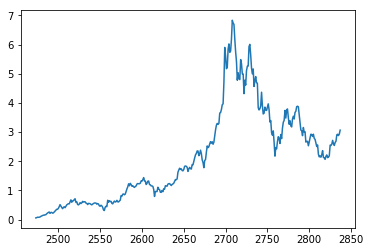

In [142]:
plt.plot(X,Y)

## NOTES

#### Possible problems
* GP Assumes that the observations come from Gaussian process, do we satisfy this?
    * * "The assumption that our observations came from a Gaussian process is a very strong assumption" https://blog.sigopt.com/posts/intuition-behind-gaussian-processes
* The toy dataset did not work, with periodic kernel :s

#### Approaches
* Data by weekday
* ~~Two dimensional. Weekday + weeknumber?~~
    * * Periodic kernel defined only for 1dim
    
    
#### Meeting with Michael
* Fourier transform
* log-transform data
* non-stationary kernels
* Brownian motion kernel
* Make some more complicated toy data with linear/RBF trend. Do experiments with data with and without periodicity. See if variance of periodic kernel is different
    *  goal is to show if modeling periodicity like this even makes sense

In [164]:
#Tinka's cool stuff
# http://www.cs.toronto.edu/~duvenaud/cookbook/                                                            Affects of addition and multiplication of kernels
# http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/basic_kernels.ipynb              Lecture link: Kernel overview
# http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/basic_gp.ipynb                   Lecture link: GP Regression tutorial

RBF = GPy.kern.RBF(input_dim=1)
RBF3 = GPy.kern.RBF(input_dim=1)
RBF2 = GPy.kern.RBF(input_dim=1, variance=20000., lengthscale=20.)
PERIODIC = GPy.kern.PeriodicMatern52(input_dim=1,period=7)
PERIODIC2 = GPy.kern.PeriodicMatern52(input_dim=1,period=20)#when larger period, error: non-positive diagonal elements
EXP_PER = GPy.kern.PeriodicExponential(input_dim=1,period=7)
EXP_PER.period.fix() #if you don' t keep this fixed, it finds a period of 5.3
LIN = GPy.kern.Linear(1)
LIN2 = GPy.kern.Linear(1,variances=1000)
BIAS = GPy.kern.Bias(input_dim=1, variance=2)
BIAS2 = GPy.kern.Bias(input_dim=1, variance=35)
BIAS3 = GPy.kern.Bias(input_dim=1, variance=35)
LIN_BIAS = GPy.kern.Bias(input_dim=1, variance=350000)
EXP = GPy.kern.Exponential(1)
RQ=GPy.kern.RatQuad(1)
RQ2=GPy.kern.RatQuad(input_dim=1, variance=3)

RBF_PER = LIN#+BIAS + EXP_PER
LIN_BIAS = LIN + LIN_BIAS
RBF_BIAS = RBF2 + BIAS2
EXP = EXP + LIN + BIAS3



 /m/home/home2/27/holopaj7/unix/Envs/CS-Major/lib/python3.5/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


GP_regression.,value,constraints,priors
sum.RatQuad.variance,890.3185267978665,+ve,
sum.RatQuad.lengthscale,1.6355530624022565,+ve,
sum.RatQuad.power,8.162988506490204e-05,+ve,
sum.mul.periodic_Matern52.variance,2.453798912997938e-62,+ve,
sum.mul.periodic_Matern52.lengthscale,179.0970256361983,+ve,
sum.mul.periodic_Matern52.period,7.373514229270616e-14,+ve,
sum.mul.rbf.variance,2.4537989129953574e-62,+ve,
sum.mul.rbf.lengthscale,5.6739428952758216e-15,+ve,
sum.rbf.variance,7.030045949218987e-202,+ve,
sum.rbf.lengthscale,464.6340656141659,+ve,


(array([[-23.2786593]]), array([[51.83808818]]))


 /m/home/home2/27/holopaj7/unix/Envs/CS-Major/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


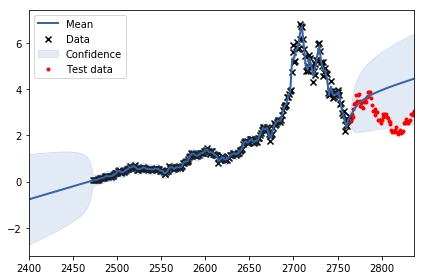

In [175]:
RBF = GPy.kern.RBF(input_dim=1)
RBF3 = GPy.kern.RBF(input_dim=1)
PERIODIC = GPy.kern.PeriodicMatern52(input_dim=1,period=7)
LIN = GPy.kern.Linear(1)
RQ=GPy.kern.RatQuad(1)
RQ2=GPy.kern.RatQuad(input_dim=1, variance=3)

KERNEL = RQ + PERIODIC*RBF3 + RBF + LIN
m = GPy.models.GPRegression(X_train, Y_train, KERNEL)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

GP_regression.,value,constraints,priors
rbf.variance,3.5513880307327543,+ve,
rbf.lengthscale,5.191879422341259,+ve,
Gaussian_noise.variance,0.01788967198351954,+ve,


(array([[0.]]), array([[3.5692777]]))


 /m/home/home2/27/holopaj7/unix/Envs/CS-Major/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


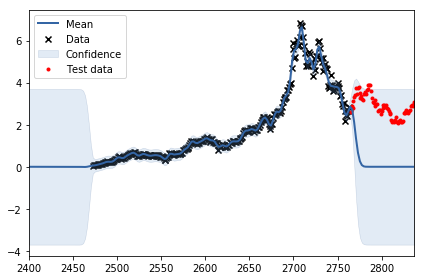

In [169]:
m = GPy.models.GPRegression(X_train, Y_train, RBF)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

GP_regression.,value,constraints,priors
sum.rbf.variance,1.761103007572734,+ve,
sum.rbf.lengthscale,4.852533087959862,+ve,
sum.bias.variance,3.5460699287567046,+ve,
Gaussian_noise.variance,0.01770574215734097,+ve,


(array([[1.86461895]]), array([[1.8481055]]))


 /m/home/home2/27/holopaj7/unix/Envs/CS-Major/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


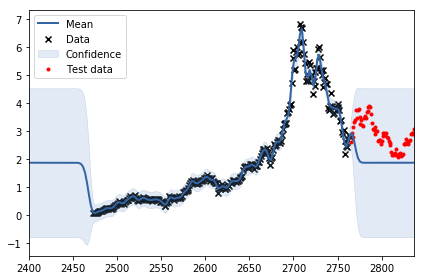

In [170]:
RBF_PER = RBF+BIAS
m = GPy.models.GPRegression(X_train, Y_train, RBF_PER)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

GP_regression.,value,constraints,priors
sum.rbf.variance,1.6640024569627372,+ve,
sum.rbf.lengthscale,4.824146700994804,+ve,
sum.linear.variances,5.43788886486383e-07,+ve,
Gaussian_noise.variance,0.017690253264881304,+ve,


(array([[0.32892745]]), array([[1.68361789]]))


 /m/home/home2/27/holopaj7/unix/Envs/CS-Major/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


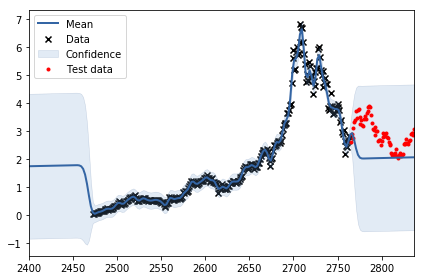

In [171]:
RBF_PER = RBF+LIN
m = GPy.models.GPRegression(X_train, Y_train, RBF_PER)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

GP_regression.,value,constraints,priors
sum.rbf.variance,1.6640041025749326,+ve,
sum.rbf.lengthscale,4.824148147215242,+ve,
sum.linear.variances,5.437986461564544e-07,+ve,
sum.periodic_Matern52.variance,0.8187456100800539,+ve,
sum.periodic_Matern52.lengthscale,1.4812280961743682,+ve,
sum.periodic_Matern52.period,0.08857487673396797,+ve,
Gaussian_noise.variance,0.017690177633608688,+ve,


(array([[0.32892755]]), array([[1.68361947]]))


 /m/home/home2/27/holopaj7/unix/Envs/CS-Major/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


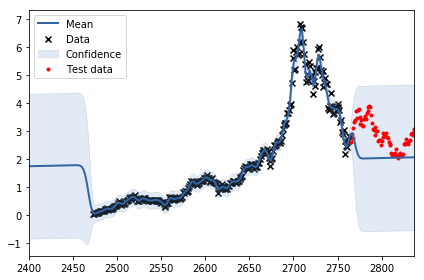

In [148]:
RBF_PER = RBF+LIN+PERIODIC
m = GPy.models.GPRegression(X_train, Y_train, RBF_PER)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

GP_regression.,value,constraints,priors
sum.rbf.variance,1.6636911616669299,+ve,
sum.rbf.lengthscale,4.798930407068935,+ve,
sum.linear.variances,5.455839539047569e-07,+ve,
sum.mul.periodic_Matern52.variance,0.5602826577699298,+ve,
sum.mul.periodic_Matern52.lengthscale,5.215313153177804,+ve,
sum.mul.periodic_Matern52.period,4.838509009370852,+ve,
sum.mul.linear.variances,1.3276252185065223e-07,+ve,
Gaussian_noise.variance,0.016432824123833206,+ve,


(array([[0.3325165]]), array([[1.68204214]]))


 /m/home/home2/27/holopaj7/unix/Envs/CS-Major/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


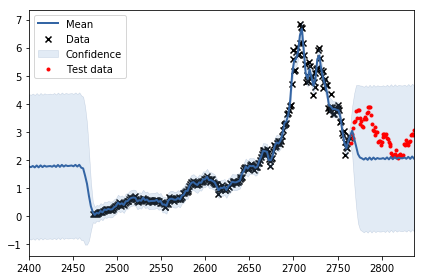

In [149]:
#WTF, why??? 
#Multiplying with RBF or RQ gives almost same as not including any periodicity at all.. 
RBF_PER = RBF+LIN+PERIODIC*LIN
m = GPy.models.GPRegression(X_train, Y_train, RBF_PER)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

GP_regression.,value,constraints,priors
sum.rbf.variance,1.6639452165020832,+ve,
sum.rbf.lengthscale,4.824874095353609,+ve,
sum.linear.variances,5.437711842149337e-07,+ve,
sum.periodic_Matern52.variance,0.0009282934569603632,+ve,
sum.periodic_Matern52.lengthscale,4.833020079521109,+ve,
sum.periodic_Matern52.period,7.0,+ve fixed,
Gaussian_noise.variance,0.01767736522854889,+ve,


(array([[0.3274029]]), array([[1.68356052]]))


 /m/home/home2/27/holopaj7/unix/Envs/CS-Major/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


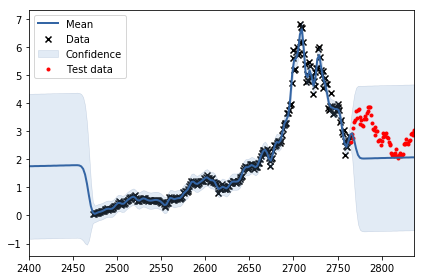

In [150]:
PERIODIC2 = GPy.kern.PeriodicMatern52(input_dim=1,period=7)
PERIODIC2.period.fix()
RBF_PER = RBF+LIN+PERIODIC2
m = GPy.models.GPRegression(X_train, Y_train, RBF_PER)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

GP_regression.,value,constraints,priors
sum.rbf.variance,1.663977890158139,+ve,
sum.rbf.lengthscale,4.824694408048426,+ve,
sum.linear.variances,5.436411362005826e-07,+ve,
sum.periodic_Matern52.variance,0.04820184429421765,+ve,
sum.periodic_Matern52.lengthscale,10.410699428825195,+ve,
sum.periodic_Matern52.period,5.762713485183978,+ve,
sum.periodic_Matern52_1.variance,0.000918636805322907,+ve,
sum.periodic_Matern52_1.lengthscale,4.820198114870954,+ve,
sum.periodic_Matern52_1.period,7.0,+ve fixed,
Gaussian_noise.variance,0.01766389665798707,+ve,


(array([[0.32725345]]), array([[1.68358828]]))


 /m/home/home2/27/holopaj7/unix/Envs/CS-Major/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


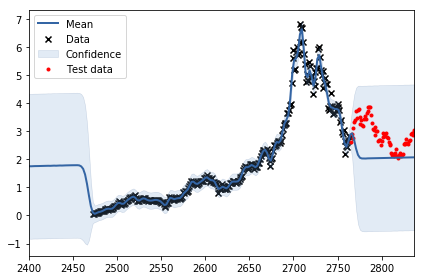

In [151]:
PERIODIC2 = GPy.kern.PeriodicMatern52(input_dim=1,period=7)
PERIODIC2.period.fix()
RBF_PER = RBF+LIN+PERIODIC+PERIODIC2
m = GPy.models.GPRegression(X_train, Y_train, RBF_PER)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

GP_regression.,value,constraints,priors
RatQuad.variance,12.282693320832388,+ve,
RatQuad.lengthscale,1.8688373600183887,+ve,
RatQuad.power,0.007981463417954079,+ve,
Gaussian_noise.variance,0.00896859518000858,+ve,


(array([[1.69209748]]), array([[1.83116611]]))


 /m/home/home2/27/holopaj7/unix/Envs/CS-Major/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


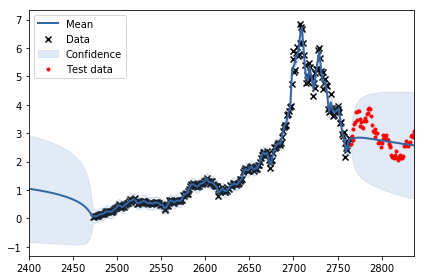

In [152]:
m = GPy.models.GPRegression(X_train, Y_train, RQ)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

### All data, same tests as above

In [115]:
## PREPROCESSING

df["Weekday"] = df.index.weekday                 ## 0 = Monday, 6 = Sunday

Y = np.array(df["Close Price"]).reshape(-1, 1)

X = np.array(df["Dataindex"]).reshape(-1, 1)

train_per=0.8
split_ind=int(len(X)*train_per)
X_train=X[:split_ind]
Y_train=Y[:split_ind]
X_test=X[split_ind:]
Y_test=Y[split_ind:]

 /m/home/home2/27/holopaj7/unix/Envs/CS-Major/lib/python3.5/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


GP_regression.,value,constraints,priors
linear.variances,0.04687883023133125,+ve,
Gaussian_noise.variance,29289.302106928753,+ve,


(array([[97.43115764]]), array([[29290.82403852]]))


 /m/home/home2/27/holopaj7/unix/Envs/CS-Major/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


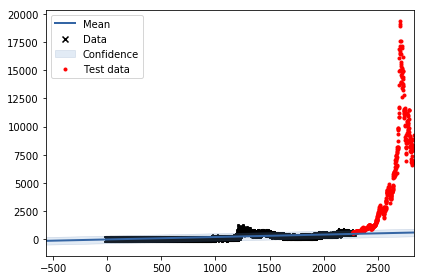

In [116]:
m = GPy.models.GPRegression(X_train, Y_train, LIN)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

In [117]:
m = GPy.models.GPRegression(X_train, Y_train, RBF)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

 /m/home/home2/27/holopaj7/unix/Envs/CS-Major/lib/python3.5/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


KeyboardInterrupt caught, calling on_optimization_end() to round things up


KeyboardInterrupt: 

In [ ]:
RBF_PER = RBF+BIAS
m = GPy.models.GPRegression(X_train, Y_train, RBF_PER)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

In [ ]:
RBF_PER = RBF+LIN
m = GPy.models.GPRegression(X_train, Y_train, RBF_PER)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

In [ ]:
RBF_PER = RBF+BIAS+LIN
m = GPy.models.GPRegression(X_train, Y_train, RBF_PER)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

In [ ]:
m = GPy.models.GPRegression(X_train, Y_train, RQ)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))